#                   Experiments for Regression using Ozone Dataset (Univariate)

Data frame with components: ozone, radiation, temperature, and wind. Measurements of daily ozone concentration (ppb), wind speed (mph), daily maximum tempera- ture (degrees F), and solar radiation(langleys) on 111 days from May to September 1973 in New York.  This data frame is similar to air in S-PLUS (or library(data) in S), but has a different definition for ozone (air contains cube-roots of
ozone).

<br>Target = ozone
<br>Predictor = wind

In [2]:
import pandas as pd
ozone = pd.read_csv("ozone_data.csv")
ozone.describe()

,ozone,radiation,temperature,wind
count,111.000000,111.000000,111.000000,111.000000
mean,42.036036,184.801802,77.792793,9.947748
std,33.179382,91.152302,9.529969,3.549644
min,1.000000,7.000000,57.000000,2.300000
25%,18.000000,113.500000,71.000000,7.400000
50%,31.000000,207.000000,79.000000,9.700000
75%,62.000000,255.500000,84.500000,11.500000
max,168.000000,334.000000,97.000000,20.700000


In [27]:
#Utilities
import numpy as np 

def rademacher_variables(vec_size):
    if vec_size % 2 != 0:
        return("Error, vector size should be even.")
    s = np.random.binomial(1,0.5, vec_size)
    a = sum(s)
    while a.all() !=0:
        s = np.random.binomial(1,0.5, vec_size)
        s[s < 1] = -1
        a = sum(s)
    return(s)
      
def rademacher_bound(array_x, delta, train_error, array_Rademacher):
    c =3*(np.sqrt(np.log(2/delta))/(2*(array_x)))
    bound = np.add(train_error, array_Rademacher)
    bound = np.add(bound,c)
    return(bound)

def vc_dimension_regression(array_x, array_Rademacher):
    c = array_x/(2*np.log(array_x))
    VC = (array_Rademacher**2)*c
    return(VC)

def VC_bound(array_x, train_error, array_VCdim, delta):
    a = array_VCdim/array_x #VC/#samples
    b = np.log(array_x/array_VCdim)
    c = np.log(delta/4)
    VCbound = train_error/abs((1-0.1*np.sqrt(a+a*b-c)))
    return(VCbound)

### Experiment 1:  Evaluating how train and test error varies with increasing training set size.

<br>Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Test Samples = 20
<br>Train Samples = [4,8,12,....,36]
<br>We run each sample size 100 times and take the average for calculating the empirical erros to reduce noise. 


In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.datasets import load_boston
from random import sample

n = range(4,40, 4)
n_2 = range(0,100,1)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []

#Test set
df_x = np.array(ozone['wind']).reshape(-1,1)
df_y = np.array(ozone['ozone']).reshape(-1,1)
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.2)


for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - train set
        idx = sample(range(0,len(X)), value)
        X_train = X[idx]
        Y_train = Y[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        #initialisation of linear regression model
        m = LinearRegression()

        #inserting train data into model for training
        m.fit(X_train,Y_train)

        #predicting values for test data
        Y_pred_test = m.predict(X_test)
        Y_pred_train = m.predict(X_train)

        #computing RMSE
        error_test= np.sqrt(mean_squared_error(Y_test, Y_pred_test))
        temp_test.append(error_test)

        error_train= np.sqrt(mean_squared_error(Y_train, Y_pred_train))
        temp_train.append(error_train)

         #Rademacher constant      
        temp_L.append(float(2*(np.dot(s, np.sqrt((Y_train-Y_pred_train)**2))/len(Y_train))))
    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(np.array(n), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)

Rademacher Constant
[30.195983103530715, 31.679787234042564, 19.467635991766418, 19.51052507663225, 22.746393016318414, 16.877107451447017, 10.238206278554127, 11.89391606922116, 14.425990215588412]
Rademacher Bound
[47.39982652 54.76224486 43.86754117 44.72286366 48.02165624 42.60495547
 35.63134561 38.59001847 40.76199103]


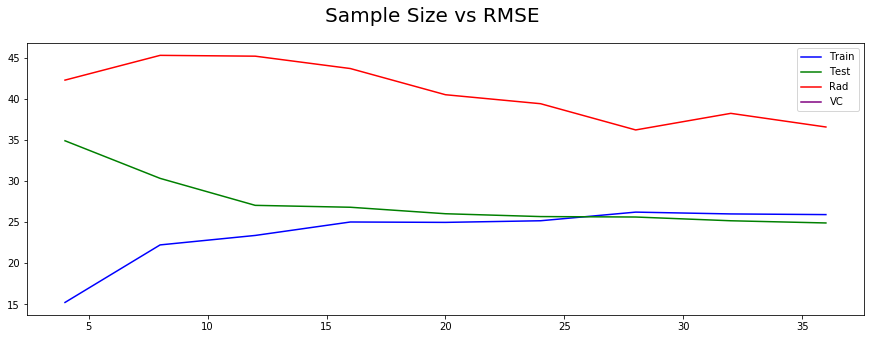

In [24]:
#Step 3: Evaluation

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE',fontsize=20)
ax.plot(n,train_error,color='blue', label = 'Train')
ax.plot(n,test_error,color = 'green', label = 'Test')
ax.plot(n,radBound.reshape(-1,1), color = 'red', label = 'Rad')
ax.plot(n, VCBound.reshape(-1,1), color = 'purple', label = 'VC')
ax.legend(loc='upper right')
plt.show()



In [29]:
#Step 4: Symbolic Regression (finding closed formula for test error depending only on sample size)
import gplearn as gpl 
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]

#fitting sumbolic regressor
est_gp = SymbolicRegressor(population_size=1000,
                           generations=10, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=5, random_state=0,
                           function_set = f_set)

sample = []
for i in n: 
    sample.append(i)  
sample = np.array([sample])
print(sample)

est_gp.fit(sample.reshape(-1,1),np.dot(1000,test_error))
print(est_gp._program)

[[ 4  8 12 16 20 24 28 32 36]]
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.73      1.02774e+15        5          10246.7          5070.09      7.04s
   1     9.48      2.90217e+08       13          5981.72          7607.34      7.23s
   2    11.67       2.3608e+09       11          3986.17             3951      7.48s
   3    14.27      7.63099e+07       14          3015.12          832.092      6.09s
   4    14.54      5.87217e+08       12           2313.1          38031.1      4.98s
   5    18.11      3.78872e+07        9          1301.51          12842.6      4.42s
   6    17.98      4.53865e+07       37          1214.29          13191.5      3.41s
   7    19.61      1.45737e+10       43          1214.29          13191.5      2.34s
   8    17.36      3.78631e+07       31     

MSE (test_error x symbolic regressor)
0.5491033335010619


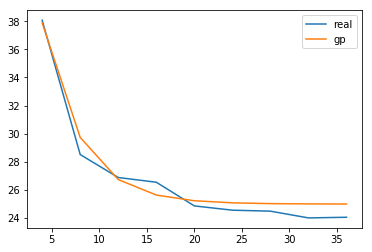

In [37]:
#Step 5: Evaluation for Symbolic Regressor
print("MSE (test_error x symbolic regressor)")
y = (np.sqrt((np.sqrt(np.exp(-sample))))*35)+25
print(mean_squared_error(test_error, y.reshape(-1,1)))

plt.plot(sample.reshape(-1,1),test_error, label = 'real')
plt.plot(sample.reshape(-1,1),y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()


### Conclusions experiment 1: 
**Theoretical expectations for Empirical Error Estimation:**
<br>Similar conclusions as in Boston dataset.
<br>**Symbolic Regression Results:**
<br>Similar conclusions as in Boston dataset. Close-form expression for test error is:
$$ (c*\sqrt[4]{e^{-n}}+b) $$

### Experiment 2:  Evaluating how train and test error varies with increasing model capacity
Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Test Samples = 20
<br>Train Samples = 10
<br>Varying model capacity by adding polynomials with degrees = [1,2,3...,10]
<br>Run each polynomial 100 times and take the average for calculating the empirical erros to reduce noise. 


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.datasets import load_boston
from random import sample

samples = 10
n_2 = range(0,100,1)
pw = range(1,11,1)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []
h = 0

#Test set
df_x = np.array(ozone['wind']).reshape(-1,1)
df_y = np.array(ozone['ozone']).reshape(-1,1)
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.2)


for i in pw:
    print("polyonomial: " + str(i))
    for j in n_2:
        #step 1 - train set
        idx = sample(range(0,len(X)), samples)
        X_train = X[idx]
        Y_train = Y[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #calculating polinomial features from 1 to 10 degree
        poly = PolynomialFeatures(degree = h+1) 
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.fit_transform(X_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        #initialisation of linear regression/insert data for training/prediction
        m = LinearRegression()

        #inserting train data in model for training
        m.fit(X_poly_train,Y_train)

        #predicting values for test data
        Y_pred_test = m.predict(X_poly_test)
        Y_pred_train = m.predict(X_poly_train)

        #computing RMSE
        error_test= np.sqrt(mean_squared_error(Y_test, Y_pred_test))
        temp_test.append(error_test)

        error_train= np.sqrt(mean_squared_error(Y_train, Y_pred_train))
        temp_train.append(error_train)

         #Rademacher constant      
        temp_L.append(float(2*(np.dot(s, np.sqrt((Y_train-Y_pred_train)**2))/len(Y_train))))
    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()
    h += 1

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound((np.array(samples))*np.ones(len(pw)), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)

polyonomial: 1
polyonomial: 2
polyonomial: 3
polyonomial: 4
polyonomial: 5
polyonomial: 6
polyonomial: 7
polyonomial: 8
polyonomial: 9
polyonomial: 10
Rademacher Constant
[27.019968752763635, 19.80623321637487, 17.9244756666885, 17.164703438865853, 14.292366097032914, 15.991670118628736, 21.799999499277327, 17.399999953832836, 15.388116685897739, 20.800000000623093]
Rademacher Bound
[49.3926531  37.86268956 35.77822067 33.15334455 27.81195679 27.91250906
 31.54976926 25.5315999  23.64311187 29.81618641]


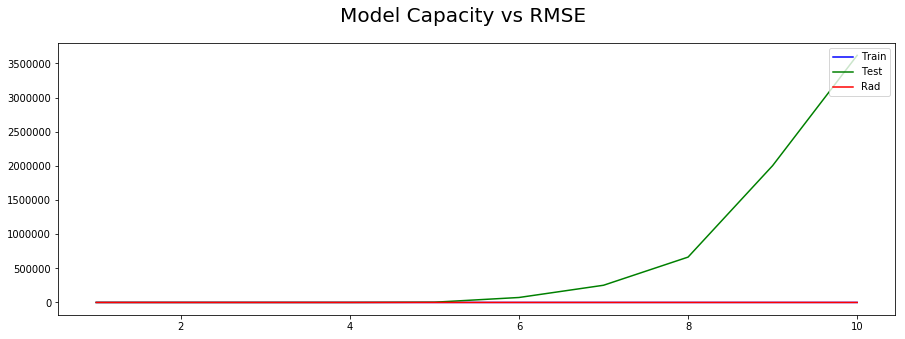

In [39]:
#Step 3: Evaluation

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
fig.suptitle('Model Capacity vs RMSE',fontsize=20)
ax.plot(pw,train_error,color='blue', label = 'Train')
ax.plot(pw,test_error,color = 'green', label = 'Test')
ax.plot(pw,radBound.reshape(-1,1), color = 'red', label = 'Rad')
ax.legend(loc='upper right')
plt.show()



In [40]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=1000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.2, random_state=0,
                           function_set = f_set)

power = []
for i in pw: 
    power.append(i)  
print(power)
power = np.array([power])
print(test_error)
est_gp.fit(power.reshape(-1,1), test_error)
print(est_gp._program)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[29.40755766885754, 33.67434502714313, 60.242242959901894, 215.7085176526216, 3537.2066369649256, 72521.6850347214, 251699.88169379457, 663997.6644563444, 2003101.757888101, 3618221.787941566]
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.73      6.44629e+09       12           332744      3.61808e+06     15.72s
   1    11.11      9.65551e+06       14           184932          1336.95     18.03s
   2    10.05      1.32735e+09       14           152115           296686     15.34s
   3     9.50      2.12913e+10       20          86949.5           852204     14.20s
   4    12.26      6.38015e+10       19          34590.8      3.34726e+06     14.10s
   5    15.83      1.46568e+11       19          28358.7      2.98999e+06     14.29s
   6    16.31      4

15461318016.46732


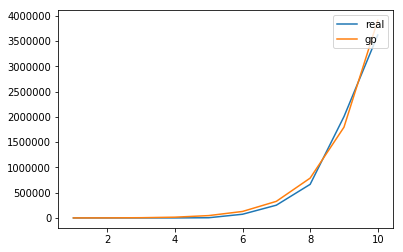

In [48]:
#Step 5: Evaluation for Symbolic Regressor
y = np.exp(np.sqrt(power)*4.8)
print(mean_squared_error(test_error, y.reshape(-1,1)))
plt.plot(power.reshape(-1,1),test_error, label = 'real')
plt.plot(power.reshape(-1,1),y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()

### Conclusions experiment 2: 

**Theoretical expectations for Empirical Error Estimation:**
<br>Same results as in Boston dataset and Multivariate case for Ozone dataset. 
<br>**Symbolic Regression Results:**
<br>Same results as in Boston dataset and Multivariate case for Ozone dataset. 


## Experiment 3:  Evaluating how train and test error varies by changing model capacity and sample size at the same time
Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Test Samples = 20
<br>Train Samples = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
<br>Varying model capacity by adding polynomials with degrees = [1,2,3...,6]
<br>Run each polynomial 100 times and take the average for calculating the empirical erros to reduce noise. 

In [69]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from random import sample
import pandas as pd
import numpy as np

n = range(4,32, 2)
n_2 = range(0,100,1)
pw = range(1,7,1)
test_error = np.zeros([len(pw),len(n)])
train_error = np.zeros([len(pw),len(n)])
Rad = np.zeros([len(pw),len(n)])
temp = []
temp2= []
temp_train = []
temp2_train = []
temp_L = []
temp_L2 = []


#Test set
df_x = np.array(ozone['wind']).reshape(-1,1)
df_y = np.array(ozone['ozone']).reshape(-1,1)
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.2)


for counter,value in enumerate(n): 
    print("Samples: ", str(value))
    for i in pw:
        print("power: ", str(i))
        for j in n_2:   
            #step 1 - train set
            idx = sample(range(0,len(X)), value)
            X_train = X[idx]
            Y_train = Y[idx]

            Y_pred_train = np.empty_like(Y_train)
            Y_pred_test = np.empty_like(Y_test)

            #creating polynomialfeatures
            poly = PolynomialFeatures(degree = i) 
            X_train_poly = poly.fit_transform(X_train) 
            X_test_poly = poly.fit_transform(X_test) 

            #rademacher sigma
            s = rademacher_variables(len(Y_train))
            
            #step 2 - model training
            #initialisation of linear regression 
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(X_train_poly,Y_train)

            #predicting values for test data
            Y_pred = m.predict(X_test_poly)
            Y_pred_train = m.predict(X_train_poly)

            #computing RMSE for train and test
            error = np.sqrt(mean_squared_error(Y_test, Y_pred))
            temp.append(error) 
            error_train = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
            temp_train.append(error_train)
            
            #computing Rademacher constant
            L = (2*np.dot(s, np.sqrt((Y_train-Y_pred_train)**2)))/len(Y_train)
            temp_L.append(L)


        temp2.append(sum(temp) / len(temp))
        temp2_train.append(sum(temp_train)/len(temp_train))
        temp_L2.append(max(temp_L))
        temp.clear()
        temp_train.clear()
        temp_L.clear()
    test_error[:,counter] = temp2
    train_error[:,counter] = temp2_train
    Rad[:,counter] = temp_L2
    temp2.clear()
    temp2_train.clear()
    temp_L2.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = np.zeros([len(pw),len(n)])
c =3*(np.sqrt(np.log(2/0.1))/(2*(np.array(n))))
for i in range(0,len(pw)):
    radBound[i] = np.add(train_error[i], Rad[i])
    radBound[i] = np.add(radBound[i],c)
print("Rademacher Bound")
print(radBound)

Samples:  4
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  6
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  8
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  10
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  12
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  14
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  16
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  18
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  20
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  22
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  24
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  26
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  28
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  30
power:  1
power:  2
power:  3
power:  4
p

Min RMSE:  30.6069079920202
Position of min RMSE:  (array([1], dtype=int64), array([13], dtype=int64))
[1, 2, 3, 4, 5, 6]
[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

Min RMSE for each polynomial 
[ 32.2018064   30.60690799  34.91467238  58.57485656 124.08808551
 424.96361724]


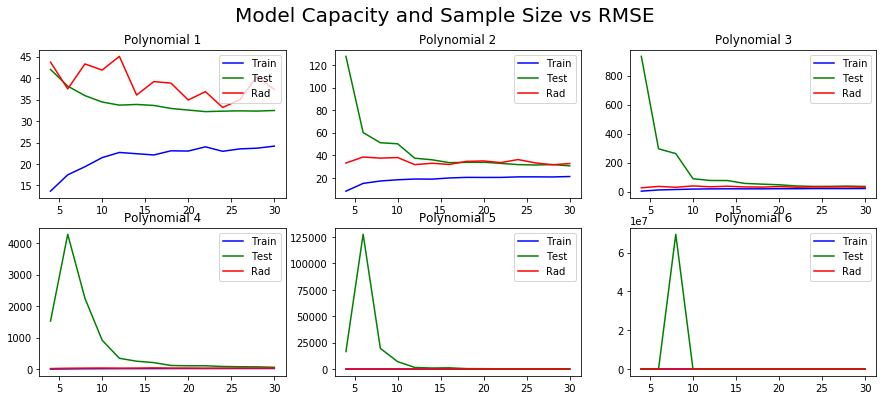

In [71]:
#Step 3: evaluation
import matplotlib.pyplot as plt

print("Min RMSE: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min RMSE: ', pos)
print(list(pw))
print(list(n))

print('\nMin RMSE for each polynomial ')
print(np.amin(test_error, axis = 1))


#plotting
fig, axs = plt.subplots(2,3, figsize=(15, 6))
fig.suptitle('Model Capacity and Sample Size vs RMSE',fontsize=20)
axs = axs.flatten()
for i in pw:
    axs[i-1].plot(n, train_error[i-1,:], color = 'blue', label = 'Train')
    axs[i-1].plot(n, test_error[i-1,:], color = 'green', label = 'Test')
    axs[i-1].plot(n, radBound[i-1], color = 'red', label = 'Rad')
    axs[i-1].legend(loc='upper right')
    axs[i-1].set_title("Polynomial %d" %i)
plt.show()

In [72]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=2000, metric = 'rmse',
                           generations=30, stopping_criteria=5000,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=10, random_state=0,
                           function_set = f_set)
power = []
samples = []
for i in pw: 
    power.append(i)  
for i in n: 
    samples.append(i)  

a = np.transpose([ np.repeat(samples, len(power)), np.tile(power, len(samples))])
error = np.array(list(test_error.flatten()))
est_gp.fit(a,1000*error)
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.59      6.87566e+17        5      8.57626e+06      2.31504e+10     47.97s
   1    10.33      6.19735e+14        5      1.56416e+07      2.31503e+10     56.40s
   2    10.05      9.37704e+09        1      1.57065e+07      2.31503e+10     56.33s
   3    11.48      1.59125e+14        7      8.71059e+06      2.31504e+10     55.99s
   4    11.93      9.66148e+14        5      8.61703e+06      2.31504e+10     52.58s
   5    10.35      6.80561e+15        3      8.60944e+06      2.31504e+10     50.43s
   6    10.35      3.02434e+14       11       8.5737e+06      2.31504e+10     49.27s
   7    10.80      1.58172e+14        1       8.4812e+06      2.31504e+10     42.29s
   8     9.67      9.61272e+12        8      7.51667e+06      2.31504e+10  

c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


  24    14.21      7.30761e+09       40      8.70911e+06      2.31504e+10     10.94s
  25    15.31      1.19186e+14        5      8.70993e+06      2.31504e+10      9.28s
  26    14.14        7.709e+09        4      8.60847e+06      2.31504e+10      6.53s
  27    13.82      5.51979e+16       36       7.8848e+06      2.31504e+10      4.36s
  28    13.64      7.52749e+09        2      5.27557e+06      2.31504e+10      2.14s
  29    14.26      7.26253e+09        6      8.49681e+06      2.31504e+10      0.00s
div(mul(0.277, X1), log(X0))


[ 5.81206139  6.50520857  6.91067367  7.19835575  7.4214993   7.60382085
  7.23237557  7.92552275  8.33098786  8.61866993  8.84181348  9.02413504
  9.00498621  9.69813339 10.10359849 10.39128057 10.61442412 10.79674568
 10.87463015 11.56777734 11.97324244 12.26092452 12.48406807 12.66638962
 12.78719955 13.48034673 13.88581184 14.17349391 14.39663746 14.57895902
 14.72317166 15.41631884 15.82178395 16.10946602 16.33260957 16.51493113
 16.67355885 17.36670603 17.77217114 18.05985321 18.28299676 18.46531832
 18.6335724  19.32671958 19.73218469 20.01986676 20.24301031 20.42533187
 20.600396   21.29354318 21.69900829 21.98669036 22.20983391 22.39215547]
MSE (test_error x symbolic regressor)
1177118784.922161


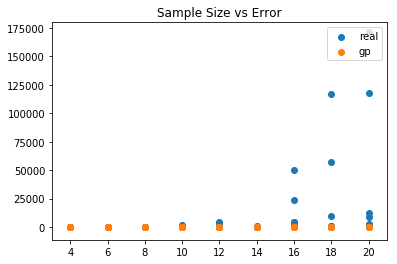

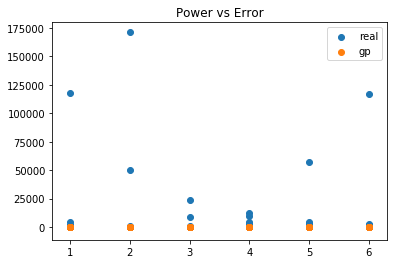

In [68]:
#Step 5: Evaluation for Symbolic Regressor
y =(a[:,0] +np.log(2*a[:,1]/np.log(np.log(a[:,0]))))

print(y)
print("MSE (test_error x symbolic regressor)")
print(mean_squared_error(error, y.reshape(-1,1)))

plt.title("Sample Size vs Error")
plt.scatter(a[:,0],error, label = 'real')
plt.scatter(a[:,0],y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()
plt.title("Power vs Error")
plt.scatter(a[:,1],error, label = 'real')
plt.scatter(a[:,1],y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()

### Conclusions experiment 3: 
**Empirical Error Estimation Results:**
<br>For univariate regression and this dataset, the best results were found when power = 2 at a model trained with 30 samples.
<br>As in all other experiments, once model capacity is added the theoretical bounds do not approximate test_error well. 

**Symbolic Regression Results:**
<br>For this experiment, symbolic regression fails to find meaningful closed form for test error as opposed to the multivariate case for the same dataset.